# Load packages

In [1]:
import os
import sys
import swat
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
swat.options.cas.print_messages=True

# Connect to CAS

In [2]:
#User and password
user = 'yen'
import getpass
pwd = getpass.getpass()

········


In [3]:
# Set up a connection with CAS #
conn=swat.CAS('https://demo.sasdemo.ca/cas-shared-default-http/',5570,'yen',pwd,caslib="casuser")
conn.about()
conn.serverstatus()

NOTE: Grid node action status report: 1 nodes, 9 total actions executed.
NOTE: Grid node action status report: 1 nodes, 10 total actions executed.


[About]

 {'CAS': 'Cloud Analytic Services',
  'Copyright': 'Copyright Â© 2014-2018 SAS Institute Inc. All Rights Reserved.',
  'ServerTime': '2020-07-30T15:26:17Z',
  'System': {'Hostname': 'va82-12.capresales.local',
   'Linux Distribution': 'Red Hat Enterprise Linux Server release 7.8 (Maipo)',
   'Model Number': 'x86_64',
   'OS Family': 'LIN X64',
   'OS Name': 'Linux',
   'OS Release': '3.10.0-1127.13.1.el7.x86_64',
   'OS Version': '#1 SMP Fri Jun 12 14:34:17 EDT 2020'},
  'Version': '3.05',
  'VersionLong': 'V.03.05M0P11112019',
  'license': {'expires': '30Mar2021:00:00:00',
   'gracePeriod': 45,
   'maxCPUs': 9999,
   'site': 'iHUB 3.5 full order v2',
   'siteNum': 70180938,
   'warningPeriod': 45}}

[nodestatus]

 Node Status
 
                        name        role  uptime  running  stalled
 0  va82-12.capresales.local  controller   3.211        0        0

[server]

 Server Status
 
    nodes  actions
 0      1       10

+ Elapsed: 0.00125s, user: 0.00114s, sys: 5e-05s, mem: 0.295mb

# Load data

In [7]:
castbl=conn.read_csv('C:/Users/canyzn/Desktop/Sample Demos/Factorization Machine/ratings.csv',
                     casout=dict(name="ratings",replace=True))
indata="ratings"


NOTE: Cloud Analytic Services made the uploaded file available as table RATINGS in caslib CASUSER(yen).
NOTE: The table RATINGS has been created in caslib CASUSER(yen) from binary data uploaded to Cloud Analytic Services.


# Explore data

In [8]:
display(castbl.shape)
display(castbl.head())

mean_rating=castbl['rating'].mean()
print('Average rating = '+str(round(mean_rating,2)))

(26024289, 4)

,userId,movieId,rating,timestamp
0,244087.0,2353.0,3.0,992233688.0
1,244087.0,2355.0,4.0,992233279.0
2,244087.0,2369.0,1.0,992401473.0
3,244087.0,2384.0,3.0,992234197.0
4,244087.0,2389.0,2.0,992404442.0


Average rating = 3.53


In [9]:
#Load action set Simple for data exploration
conn.loadActionSet('simple')
actions=conn.builtins.help(actionSet='simple')

NOTE: Added action set 'simple'.
NOTE: Information for action set 'simple':
NOTE:    simple
NOTE:       mdSummary - Calculates multidimensional summaries of numeric variables
NOTE:       numRows - Shows the number of rows in a Cloud Analytic Services table
NOTE:       summary - Generates descriptive statistics of numeric variables such as the sample mean, sample variance, sample size, sum of squares, and so on
NOTE:       correlation - Computes Pearson product-moment correlations.
NOTE:       regression - Performs a linear regression up to 3rd-order polynomials
NOTE:       crossTab - Performs one-way or two-way tabulations
NOTE:       distinct - Computes the distinct number of values of the variables in the variable list
NOTE:       topK - Returns the top-K and bottom-K distinct values of each variable included in the variable list based on a user-specified ranking order
NOTE:       groupBy - Builds BY groups in terms of the variable value combinations given the variables in the variab

In [10]:
#Check missing values
conn.simple.distinct(
    table=indata,
    inputs=list(castbl)
) #no misisng values

,Column,NDistinct,NMiss,Trunc
0,userId,270896.0,0.0,0.0
1,movieId,45115.0,0.0,0.0
2,rating,10.0,0.0,0.0
3,timestamp,20549435.0,0.0,0.0


In [11]:
#Check frequency distribution of ratings
tbl=conn.simple.freq(
    table=indata,
    inputs='rating'
)['Frequency']

tbl['Proportion']=tbl['Frequency']/tbl['Frequency'].sum(axis=0)
tbl #this table is already copied in the client

,Column,NumVar,FmtVar,Level,Frequency,Proportion
0,rating,1.0,1,1,843310.0,0.032405
1,rating,2.0,2,2,1762440.0,0.067723
2,rating,3.0,3,3,5256722.0,0.201993
3,rating,4.0,4,4,6998802.0,0.268933
4,rating,5.0,5,5,3812499.0,0.146498
5,rating,0.5,0.5,6,404897.0,0.015558
6,rating,1.5,1.5,7,403607.0,0.015509
7,rating,2.5,2.5,8,1255358.0,0.048238
8,rating,3.5,3.5,9,3116213.0,0.119742
9,rating,4.5,4.5,10,2170441.0,0.083401


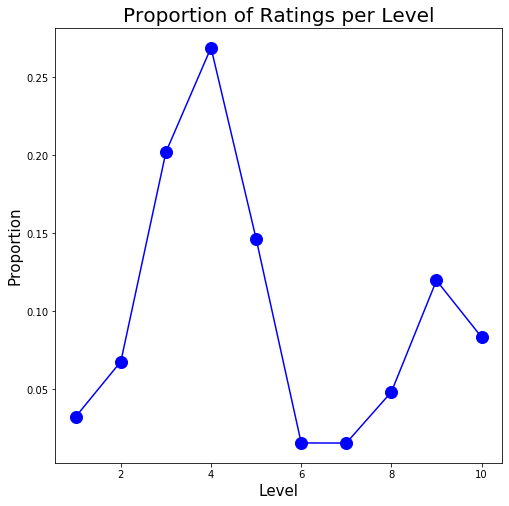

In [12]:
plt.figure(figsize=(8,8))
plt.plot(tbl['Level'],tbl['Proportion'],color="blue",linestyle='-',marker='o',markersize=12)
plt.title('Proportion of Ratings per Level', fontsize=20)
plt.xlabel('Level', fontsize=15)
plt.ylabel('Proportion',fontsize=15)
plt.show()

# Detect rating bias

In [13]:
#Load fedSQL action set
conn.loadActionSet('fedSql')
actions=conn.builtins.help(actionSet='fedSql')

NOTE: Added action set 'fedSql'.
NOTE: Information for action set 'fedSql':
NOTE:    fedSql
NOTE:       execDirect - Submits a SAS FedSQL language statement for immediate execution


In [14]:
user_bias=conn.fedSql.execDirect(query=
                                 '''
                                 SELECT userId,
                                 COUNT(rating) as Frequency,
                                 AVG(rating) as AVG_rating
                                 FROM ratings
                                 GROUP BY userId
                                 ORDER BY userId ASC;                                 
                                 '''
)['Result Set']

user_bias['user_bias']=user_bias['AVG_RATING']-mean_rating
#user bias is defined as the difference between the average rating given by a user
#..as compared to the global average rating for all users across all movies
user_bias.head()

,userId,FREQUENCY,AVG_RATING,user_bias
0,1.0,27,4.277778,0.749687
1,2.0,22,3.318182,-0.209909
2,3.0,10,3.100000,-0.428090
3,4.0,62,3.500000,-0.028090
4,5.0,26,4.269231,0.741140


In [15]:
movie_bias=conn.fedSql.execDirect(query=
                                 '''
                                 SELECT movieId,
                                 COUNT(rating) as Frequency,
                                 AVG(rating) as AVG_rating
                                 FROM ratings
                                 GROUP BY movieId
                                 ORDER BY movieId ASC;                                 
                                 '''
)['Result Set']

movie_bias['movie_bias']=movie_bias['AVG_RATING']-mean_rating
#user bias is defined as the difference between the average rating given to a movie
#...as compared to the global average rating for all movies across all users
movie_bias.head()

,movieId,FREQUENCY,AVG_RATING,movie_bias
0,1.0,66008,3.888157,0.360067
1,2.0,26060,3.236953,-0.291137
2,3.0,15497,3.175550,-0.352540
3,4.0,2981,2.875713,-0.652378
4,5.0,15258,3.079565,-0.448526


# Partition the data

In [16]:
#Load Sampling action set
conn.loadActionSet('sampling')
actions=conn.builtins.help(actionSet='sampling')

NOTE: Added action set 'sampling'.
NOTE: Information for action set 'sampling':
NOTE:    sampling
NOTE:       srs -  Samples a proportion of data from the input table or partitions the data into no more than three portions
NOTE:       stratified - Samples a proportion of data or partitions the data into no more than three portions within each stratum
NOTE:       oversample - Samples a user-specified proportion of data from the event level and adjusts the ratio between rare events and non-rare events to a user-specified ratio
NOTE:       kfold - K-fold partitioning.


In [17]:
conn.sampling.srs(
    table=indata,
    samppct=70,
    seed=649,
    partind=True,
    output=dict(casOut=dict(name=indata,replace=True),copyVars='ALL')
)

NOTE: Simple Random Sampling is in effect.
NOTE: Using SEED=649 for sampling.


[OutputCasTables]

          casLib     Name Label      Rows  Columns  \
 0  CASUSER(yen)  ratings        26024289        5   
 
                                      casTable  
 0  CASTable('ratings', caslib='CASUSER(yen)')  

[SRSFreq]

 Frequencies
 
        NObs     NSamp
 0  26024289  18217002

+ Elapsed: 0.726s, user: 8.08s, sys: 2.16s, mem: 149mb

# Train the model

In [18]:
#Declare variables
target='rating'
inputs=['userId','movieId']

In [19]:
#Load Factorization Machine action set
conn.loadActionSet('factmac')
actions=conn.builtins.help(actionSet='factmac')

NOTE: Added action set 'factmac'.
NOTE: Information for action set 'factmac':
NOTE:    factmac
NOTE:       factmac - Learns a factorization machine model


In [20]:
conn.factmac.factmac(
    table=dict(name=indata,where='_PartInd_=1'),
    target=target,
    inputs=inputs,
    nominals=inputs,
    maxIter=5,
    nFactors=10, #more factors and more interactions help to improve the model, higher computational power is needed
    learnStep=.1,
    seed=919,
    saveState=dict(name='factmac_rating',replace=True),
    output=dict(casout=dict(name='training_scored',replace=True),copyVars='ALL')
)

NOTE: Using SEED=919.
NOTE: Beginning data reading and levelization...
NOTE: Data reading and levelization complete.
NOTE: Beginning optimization of the factorization machine model...
NOTE: >>> Progress: completed iteration 1
NOTE: >>> Progress: completed iteration 2
NOTE: >>> Progress: completed iteration 3
NOTE: >>> Progress: completed iteration 4
NOTE: >>> Progress: completed iteration 5
NOTE: Optimization complete.
NOTE: Beginning scoring of the input dataset...
NOTE: Scoring of the input dataset complete.
NOTE: 33602541 bytes were written to the table "factmac_rating" in the caslib "CASUSER(yen)".


[DescStatsInt]

 Interval Variables
 
   Variable      Mean    StdDev
 0   rating  3.528172  1.065402

[DescStatsNom]

 Nominal Variables
 
   Variable  NumLevels
 0   userId   268927.0
 1  movieId    42163.0

[FinalLoss]

 Final Exact Loss
 
   Criterion     Value
 0       MSE  0.817868
 1      RMSE  0.904360

[ModelInfo]

 Model Information
 
           Description  Value
 0  Maximum Iterations    5.0
 1   Number of Factors   10.0
 2       Learning Step    0.1
 3                Seed  919.0

[NObs]

 Number of Observations
 
                           Type           N
 0  Number of Observations Read  18217002.0
 1  Number of Observations Used  18217002.0

[OptIterHistory]

    Progress  Objective      Loss
 0       1.0   0.983239  0.983239
 1       2.0   0.826787  0.826787
 2       3.0   0.771789  0.771789
 3       4.0   0.735389  0.735389
 4       5.0   0.710877  0.710877

[OutputCasTables]

          casLib             Name Label      Rows  Columns  \
 0  CASUSER(yen)  training_scored        18217002        6   
 
                                             casTable  
 0  CASTable('training_scored', caslib='CASUSER(ye...  

[outputSize]

 {'outputNObs': 18217002, 'outputNVars': 6}

+ Elapsed: 16.2s, user: 358s, sys: 8.2s, mem: 1.89e+03mb

In [21]:
conn.table.fetch(table='training_scored',to=5)

,userId,movieId,rating,timestamp,_PartInd_,P_rating
0,66021.0,185.0,3.0,839886372.0,1.0,3.794901
1,66021.0,208.0,5.0,839886372.0,1.0,3.565185
2,66021.0,225.0,4.0,839886458.0,1.0,4.002924
3,66021.0,292.0,4.0,839886341.0,1.0,4.177443
4,66021.0,296.0,3.0,839886240.0,1.0,5.720366



# Recommend Rating ~ Scoring

In [22]:
#Load aStore action set
conn.loadActionSet('aStore')
actions=conn.builtins.help(actionSet='aStore')

NOTE: Added action set 'aStore'.
NOTE: Information for action set 'aStore':
NOTE:    astore
NOTE:       download - Downloads a remote store to a local store
NOTE:       upload - Uploads a local store to a remote store
NOTE:       describe - Describes some of the contents of the analytic store
NOTE:       score - Uses an analytic store to score an input table


In [55]:
conn.aStore.score(
    table=dict(name=indata,where="_PartInd_=0"),
    rstore='factmac_rating',
    copyVars=list(castbl),
    out=dict(name='factmac_scored',replace=True)
)

[OutputCasTables]

          casLib            Name     Rows  Columns  \
 0  CASUSER(yen)  factmac_scored  7807287        6   
 
                                             casTable  
 0  CASTable('factmac_scored', caslib='CASUSER(yen)')  

[Timing]

 Task Timing
 
                  Task   Seconds   Percent
 0   Loading the Store  0.000086  0.000058
 1  Creating the State  1.014324  0.687733
 2             Scoring  0.460111  0.311965
 3               Total  1.474880  1.000000

+ Elapsed: 1.61s, user: 9.45s, sys: 1.29s, mem: 233mb

# Find the Error

In [43]:
#Load dataStep action set
conn.loadActionSet('dataStep')
actions=conn.builtins.help(actionSet='dataStep')

NOTE: Added action set 'dataStep'.
NOTE: Information for action set 'dataStep':
NOTE:    dataStep
NOTE:       runCodeTable - Runs DATA step code stored in a CAS table
NOTE:       runCode - Runs DATA step code


In [56]:
conn.dataStep.runCode(code=
                     """
                     data factmac_scored;
                     set factmac_scored;
                     error=rating-P_rating;
                     run;
                     """
                     )

NOTE: Missing values were generated as a result of performing an operation on missing values.
      Each place is given by: (Number of times) at (Line):(Column).
      53 at 0:117
      73 at 0:117
      70 at 0:117
      203 at 0:117
      167 at 0:117
      233 at 0:117
      140 at 0:117
      320 at 0:117
      225 at 0:117
      166 at 0:117
      159 at 0:117
      185 at 0:117
      179 at 0:117
      325 at 0:117
      209 at 0:117
      197 at 0:117
      113 at 0:117
      177 at 0:117
      276 at 0:117
      195 at 0:117
      156 at 0:117
      468 at 0:117
      214 at 0:117
      182 at 0:117
      171 at 0:117
      199 at 0:117
      169 at 0:117
      238 at 0:117
      232 at 0:117
      186 at 0:117
NOTE: Duplicate messages output by DATA step:
NOTE: Missing values were generated as a result of performing an operation on missing values.  (occurred 32 times)
      Each place is given by: (Number of times) at (Line):(Column).  (occurred 32 times)
      179 at 0:117  (

[InputCasTables]

          casLib            Name     Rows  Columns  \
 0  CASUSER(yen)  factmac_scored  7807287        6   
 
                                             casTable  
 0  CASTable('factmac_scored', caslib='CASUSER(yen)')  

[OutputCasTables]

          casLib            Name     Rows  Columns  Append Promoted  \
 0  CASUSER(yen)  factmac_scored  7807287        7     NaN        N   
 
                                             casTable  
 0  CASTable('factmac_scored', caslib='CASUSER(yen)')  

+ Elapsed: 0.337s, user: 2.55s, sys: 0.667s, mem: 106mb

In [57]:
conn.fedSql.execDirect(query=
                      '''
                      SELECT
                      AVG(error**2) AS MSE,
                      SQRT(AVG(error**2)) AS RMSE
                      FROM factmac_scored
                      '''
                      )

,MSE,RMSE
0,0.886998,0.941805


In [46]:
# #Python alternative code
# factmac_scored=conn.CASTable(name='factmac_scored')
# factmac_scored=factmac_scored.to_frame()

# factmac_scored['error']=factmac_scored['rating']-factmac_scored['P_rating']
# factmac_scored['err_sq']=(factmac_scored['rating']-factmac_scored['P_rating'])**2

# MSE=factmac_scored['err_sq'].mean()
# print('MSE = ' + str(round(MSE,4)))
# print ('RMSE = '+ str(round(MSE**.5,4)))

# Average Prediction per Rating 

In [58]:
rating_pred=conn.fedSql.execDirect(query=
                                  '''
                                  SELECT rating,
                                  count(*) AS Frequency,
                                  AVG(P_rating) AS avg_prediction
                                  FROM factmac_scored
                                  GROUP BY rating;
                                  '''
                                  )

In [59]:
rating_pred['Result Set'].sort_values('rating')

,rating,FREQUENCY,AVG_PREDICTION
3,0.5,121538,2.378238
8,1.0,253189,2.644333
2,1.5,121450,2.720290
7,2.0,528431,2.960554
1,2.5,376876,3.058511
6,3.0,1576581,3.327310
0,3.5,934383,3.533876
5,4.0,2100312,3.767212
9,4.5,651665,4.015260
4,5.0,1142862,4.137293


# Round the Predicted Rating

In [60]:
conn.dataStep.runCode(code=
                     '''
                     data factmac_scored;
                     set factmac_scored;
                     P_rating_round=round(P_rating,1);
                     if P_rating_round=0 then P_rating_round=1.0;
                     run;
                     '''
                     )

conn.table.fetch(table='factmac_scored',to=10)

NOTE: Missing values were generated as a result of performing an operation on missing values.
      Each place is given by: (Number of times) at (Line):(Column).
      74 at 0:120
      180 at 0:120
      543 at 0:120
      193 at 0:120
      137 at 0:120
      147 at 0:120
      196 at 0:120
      131 at 0:120
      224 at 0:120
      208 at 0:120
      176 at 0:120
      179 at 0:120
      163 at 0:120
      186 at 0:120
      219 at 0:120
      161 at 0:120
      124 at 0:120
      197 at 0:120
      320 at 0:120
      160 at 0:120
      158 at 0:120
      182 at 0:120
      254 at 0:120
      259 at 0:120
      279 at 0:120
      133 at 0:120
      157 at 0:120
      195 at 0:120
NOTE: Duplicate messages output by DATA step:
NOTE: Missing values were generated as a result of performing an operation on missing values.  (occurred 32 times)
      Each place is given by: (Number of times) at (Line):(Column).  (occurred 32 times)
      196 at 0:120  (occurred 2 times)
      176 at 0:120

,P_rating,userId,movieId,rating,timestamp,_PartInd_,error,P_rating_round
0,3.174446,12992.0,357.0,4.0,1.161032e+09,0.0,0.825554,3.0
1,2.612172,12992.0,380.0,2.5,1.161032e+09,0.0,-0.112172,3.0
2,2.616809,12992.0,468.0,3.0,1.071500e+09,0.0,0.383191,3.0
3,2.223142,12992.0,480.0,2.0,1.071499e+09,0.0,-0.223142,2.0
4,2.372842,12992.0,539.0,2.5,1.071499e+09,0.0,0.127158,2.0
5,2.866340,12992.0,589.0,2.5,1.071497e+09,0.0,-0.366340,3.0
6,3.696784,12992.0,678.0,3.5,1.071501e+09,0.0,-0.196784,4.0
7,3.318066,12992.0,745.0,4.0,1.071502e+09,0.0,0.681934,3.0
8,3.806603,12992.0,750.0,4.0,1.071495e+09,0.0,0.193397,4.0
9,2.039768,12992.0,786.0,2.0,1.161032e+09,0.0,-0.039768,2.0


In [61]:
# Find actual vs. predicted rating
crosstab=conn.simple.crossTab(
    table='factmac_scored',
    row='rating',
    col='P_rating_round'
)['Crosstab']

crosstab.head(20)


,rating,Col1,Col2,Col3,Col4,Col5,Col6,Col7,Col8,Col9,Col10,Col11,Col12,Col13,Col14,Col15
0,1,28019.0,81879.0,96699.0,40444.0,5199.0,359.0,27.0,0.0,0.0,254.0,34.0,15.0,1.0,1.0,0.0
1,2,16020.0,127343.0,258200.0,113333.0,12254.0,654.0,35.0,3.0,1.0,103.0,6.0,1.0,1.0,0.0,0.0
2,3,11103.0,150345.0,788521.0,565393.0,57307.0,2474.0,154.0,9.0,1.0,74.0,9.0,0.0,1.0,0.0,0.0
3,4,4815.0,58030.0,586974.0,1225086.0,215810.0,7992.0,389.0,21.0,0.0,41.0,8.0,1.0,0.0,0.0,0.0
4,5,2178.0,17711.0,165623.0,617105.0,316461.0,21478.0,1264.0,81.0,6.0,35.0,8.0,0.0,1.0,0.0,0.0
5,0.5,26263.0,37362.0,36487.0,17053.0,2938.0,228.0,22.0,1.0,1.0,761.0,112.0,33.0,6.0,3.0,1.0
6,1.5,8746.0,39395.0,51490.0,19318.0,2079.0,145.0,5.0,0.0,0.0,49.0,4.0,0.0,0.0,0.0,0.0
7,2.5,6737.0,70939.0,200403.0,89503.0,8217.0,427.0,17.0,0.0,0.0,43.0,4.0,1.0,0.0,0.0,0.0
8,3.5,3769.0,44752.0,382438.0,453295.0,47438.0,1717.0,103.0,5.0,1.0,28.0,3.0,0.0,0.0,0.0,0.0
9,4.5,1119.0,10099.0,106350.0,401814.0,126587.0,5053.0,251.0,9.0,1.0,10.0,2.0,0.0,0.0,0.0,0.0


In [ ]:
#Proportion of Correct Predictions
crosstab=crosstab.drop('rating',axis=1)
pd.DataFrame(np.diagonal(crosstab)).sum(axis=0)/crosstab.values.sum()

In [ ]:
#Conditional Probabilities
crosstab.divide(crosstab.sum(axis=1),axis=0)

# Top 5 Recommendation for Users

In [62]:
#Create a helper function to identify top 5 for a given user
def useri_top5(which_user):
    tmp=conn.fedSql.execDirect(query=
                              '''
                              SELECT userId, movieId, P_rating
                              FROM factmac_scored
                              WHERE userId=''' + str(which_user) + '''
                              ORDER BY P_rating DESC;
                              ''') ['Result Set']
    return tmp.head()

useri_top5(1)

,userId,movieId,P_rating
0,1.0,1221.0,6.700004
1,1.0,99114.0,6.645492
2,1.0,112552.0,5.831782
3,1.0,110.0,5.587021
4,1.0,98809.0,5.393076


# End the Session

In [ ]:
conn.session.endSession()